Egg Detection with DETR_Custom Dataset


In [1]:
# Importing libraries
import argparse
from PIL import Image
import requests
import matplotlib.pyplot as plt


import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
from models import build_model

In [2]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = [
    'None',
    'Normal',
    'Crack',
    'Bleached',
    'Impurity',
    'Deformity',
    'Latent Crack',
    'N/A'
]

In [3]:
# Create arguments class for build DETR model
class Args:
    lr_backbone = 2e-4
    masks = None
    # Model parameters
    frozen_weights = None
    backbone = 'resnet50'
    dilation = False
    position_embedding = 'sine'
    enc_layers = 6
    dec_layers = 6
    dim_feedforward = 2048
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    num_queries = 100
    pre_norm = False
    aux_loss = False
    num_classes = 8
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    num_bbox_reg_classes = 2
    # Dataset parameters
    dataset_file = 'coco'
    coco_path = ''
    remove_difficult = False
    coco_panoptic_path = None
    # Device parameters
    device = 'cuda'
    seed = 42
    # Misc
    output_dir = ''
    resume = './outputs/best_Color.pth' # Path to load weights model


args = Args()

In [4]:

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_min, y_min, w, h = x.unbind(1)
    b = [x_min - 0.5 * w, y_min - 0.5 * h, x_min + 0.5 * w, y_min + 0.5 * h]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
# Put everything on detect function
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    pil_img = plt.imread(pil_img)
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Detecting Eggs with DETR - DEMO with a Single Color Image


/home/ncl/anaconda3/envs/ttmanh/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/ncl/anaconda3/envs/ttmanh/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/ttmanh/detr_Egg_Detection/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect roundin

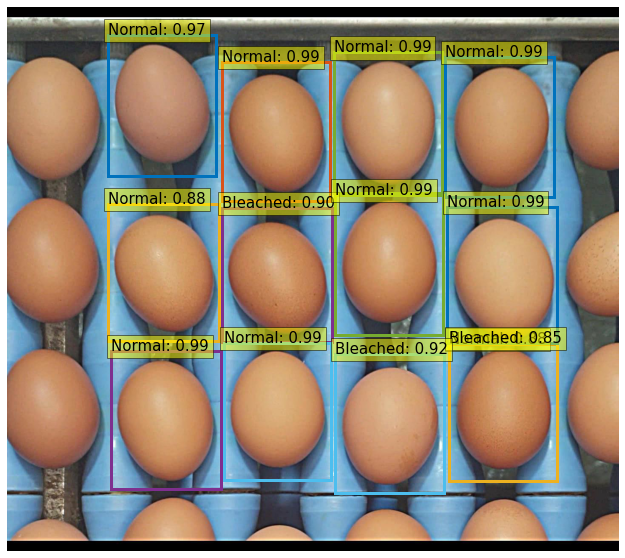

In [6]:
# Load model
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

# Inference phase visualization
image = './20220919-02026.jpg'
img = Image.open(image)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


scores, boxes = detect(img, model, transform)
plot_results(image, scores, boxes)
